In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
#Reading the train file 
train_df = pd.read_csv('train_PDjVQMB.csv')
train_df.shape

(6650, 11)

In [4]:
#checking for duplicates
train_df.drop_duplicates()
train_df.shape

(6650, 11)

In [5]:
#Reading the test file
test_df = pd.read_csv('test_lTY72QC.csv')
combine = [train_df, test_df]
test_df.shape

(2851, 10)

In [6]:
# preview the data
train_df.head(10)

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1
5,e7a8332a,31,Female,Less than 5L,111026.79,4,1,1,0,Good,0
6,f2de1836,56,Male,Less than 5L,1072102.23,2,1,2,1,Average,0
7,f422388a,41,Female,10L - 15L,1587489.75,4,0,1,1,Poor,1
8,773aa149,60,Female,10L - 15L,1465812.54,0,0,1,1,Poor,1
9,443be80f,32,Female,5L - 10L,770796.81,3,0,1,1,Poor,0


In [7]:
# looking at missing values in all the variables
train_df.apply(lambda x: sum(x.isnull()),axis=0) 

ID                    0
Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
Is_Churn              0
dtype: int64

(array([0, 1]), <a list of 2 Text xticklabel objects>)

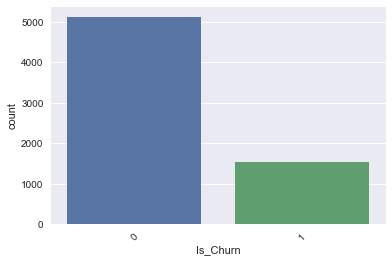

In [8]:
# Is_Churn varibale distribution
sns.countplot(x="Is_Churn", data=train_df)
plt.xticks(rotation=45)

In [9]:
# creating Age bands and determine correlations with churned
train_df['AgeBand'] = pd.cut(train_df['Age'], 10)
train_df[['AgeBand', 'Is_Churn']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Is_Churn
0,"(20.949, 26.1]",0.081081
1,"(26.1, 31.2]",0.107798
2,"(31.2, 36.3]",0.179724
3,"(36.3, 41.4]",0.225383
4,"(41.4, 46.5]",0.246994
5,"(46.5, 51.6]",0.284785
6,"(51.6, 56.7]",0.354406
7,"(56.7, 61.8]",0.396429
8,"(61.8, 66.9]",0.413793
9,"(66.9, 72.0]",0.491228


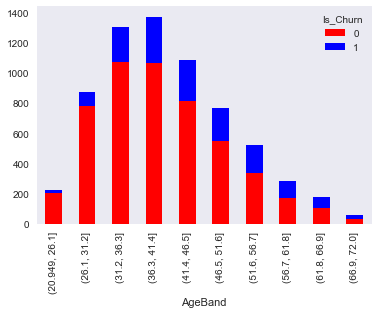

In [10]:
# Combining AgeBand and Is_Churn
temp = pd.crosstab(train_df['AgeBand'], train_df['Is_Churn'])
temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)
plt.show()

In [11]:
# replacing Age with ordinals based on these bands
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 26, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 31), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 31) & (dataset['Age'] <= 36), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 41), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 41) & (dataset['Age'] <= 46), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 46) & (dataset['Age'] <= 51), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 51) & (dataset['Age'] <= 56), 'Age'] = 6
    dataset.loc[(dataset['Age'] > 56) & (dataset['Age'] <= 61), 'Age'] = 7
    dataset.loc[(dataset['Age'] > 61) & (dataset['Age'] <= 66), 'Age'] = 8
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 9
train_df.head(10)

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn,AgeBand
0,84e2fcc9,2,Female,5L - 10L,563266.44,4,0,1,0,Average,1,"(31.2, 36.3]"
1,57fea15e,6,Female,Less than 5L,875572.11,2,1,1,1,Poor,0,"(51.6, 56.7]"
2,8df34ef3,2,Female,More than 15L,701607.06,2,1,2,0,Poor,0,"(31.2, 36.3]"
3,c5c0788b,4,Female,More than 15L,1393922.16,0,1,2,1,Poor,1,"(41.4, 46.5]"
4,951d69c4,3,Female,More than 15L,893146.23,1,1,1,1,Good,1,"(36.3, 41.4]"
5,e7a8332a,1,Female,Less than 5L,111026.79,4,1,1,0,Good,0,"(26.1, 31.2]"
6,f2de1836,6,Male,Less than 5L,1072102.23,2,1,2,1,Average,0,"(51.6, 56.7]"
7,f422388a,3,Female,10L - 15L,1587489.75,4,0,1,1,Poor,1,"(36.3, 41.4]"
8,773aa149,7,Female,10L - 15L,1465812.54,0,0,1,1,Poor,1,"(56.7, 61.8]"
9,443be80f,2,Female,5L - 10L,770796.81,3,0,1,1,Poor,0,"(31.2, 36.3]"


In [12]:
# dropping AgeBand feature
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,2,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,6,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,2,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,4,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,3,Female,More than 15L,893146.23,1,1,1,1,Good,1


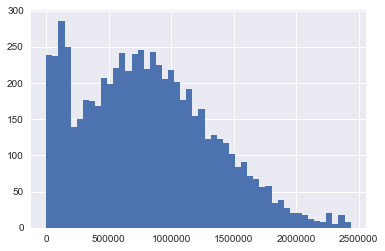

In [13]:
# plotting the histogram of Balance
train_df['Balance'].hist(bins=50)
plt.show()

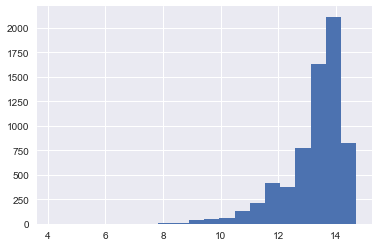

In [14]:
# Treating extreme values of Balance by log transformation
train_df['Balance_log'] = np.log(train_df['Balance'])
test_df['Balance_log'] = np.log(test_df['Balance'])
train_df['Balance_log'].hist(bins=20)
plt.show()

In [15]:
# dropping Balance feature
train_df = train_df.drop(['Balance'], axis=1)
test_df = test_df.drop(['Balance'], axis=1)
combine = [train_df, test_df]
train_df.head()

,ID,Age,Gender,Income,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn,Balance_log
0,84e2fcc9,2,Female,5L - 10L,4,0,1,0,Average,1,13.241508
1,57fea15e,6,Female,Less than 5L,2,1,1,1,Poor,0,13.682633
2,8df34ef3,2,Female,More than 15L,2,1,2,0,Poor,0,13.461129
3,c5c0788b,4,Female,More than 15L,0,1,2,1,Poor,1,14.147632
4,951d69c4,3,Female,More than 15L,1,1,1,1,Good,1,13.702506


In [16]:
train_df['Credit_Category'].value_counts()

Poor       3076
Average    2043
Good       1531
Name: Credit_Category, dtype: int64

In [17]:
# replacing Credit_Category with ordinals
for dataset in combine:    
    dataset.loc[ dataset['Credit_Category'] == 'Poor', 'Credit_Category'] = 0
    dataset.loc[ dataset['Credit_Category'] == 'Average', 'Credit_Category'] = 1
    dataset.loc[ dataset['Credit_Category'] == 'Good', 'Credit_Category'] = 2
train_df.head(10)

,ID,Age,Gender,Income,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn,Balance_log
0,84e2fcc9,2,Female,5L - 10L,4,0,1,0,1,1,13.241508
1,57fea15e,6,Female,Less than 5L,2,1,1,1,0,0,13.682633
2,8df34ef3,2,Female,More than 15L,2,1,2,0,0,0,13.461129
3,c5c0788b,4,Female,More than 15L,0,1,2,1,0,1,14.147632
4,951d69c4,3,Female,More than 15L,1,1,1,1,2,1,13.702506
5,e7a8332a,1,Female,Less than 5L,4,1,1,0,2,0,11.617527
6,f2de1836,6,Male,Less than 5L,2,1,2,1,1,0,13.885132
7,f422388a,3,Female,10L - 15L,4,0,1,1,0,1,14.277665
8,773aa149,7,Female,10L - 15L,0,0,1,1,0,1,14.197920
9,443be80f,2,Female,5L - 10L,3,0,1,1,0,0,13.555180


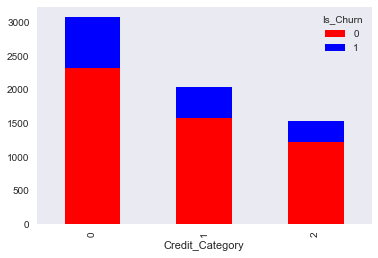

In [18]:
# Combining Credit_Category and Is_Churn
temp = pd.crosstab(train_df['Credit_Category'], train_df['Is_Churn'])
temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)
plt.show()

In [19]:
combine = [train_df, test_df]

In [20]:
train_df['Income'].value_counts()

10L - 15L        1885
5L - 10L         1847
Less than 5L     1573
More than 15L    1345
Name: Income, dtype: int64

In [21]:
# replacing Income with ordinals
for dataset in combine:    
    dataset.loc[ dataset['Income'] == 'Less than 5L', 'Income'] = 0
    dataset.loc[ dataset['Income'] == '5L - 10L', 'Income'] = 1
    dataset.loc[ dataset['Income'] == '10L - 15L', 'Income'] = 2
    dataset.loc[ dataset['Income'] == 'More than 15L', 'Income'] = 3
train_df.head(10)

,ID,Age,Gender,Income,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn,Balance_log
0,84e2fcc9,2,Female,1,4,0,1,0,1,1,13.241508
1,57fea15e,6,Female,0,2,1,1,1,0,0,13.682633
2,8df34ef3,2,Female,3,2,1,2,0,0,0,13.461129
3,c5c0788b,4,Female,3,0,1,2,1,0,1,14.147632
4,951d69c4,3,Female,3,1,1,1,1,2,1,13.702506
5,e7a8332a,1,Female,0,4,1,1,0,2,0,11.617527
6,f2de1836,6,Male,0,2,1,2,1,1,0,13.885132
7,f422388a,3,Female,2,4,0,1,1,0,1,14.277665
8,773aa149,7,Female,2,0,0,1,1,0,1,14.197920
9,443be80f,2,Female,1,3,0,1,1,0,0,13.555180


In [22]:
combine = [train_df, test_df]

In [23]:
train_df['Product_Holdings'].value_counts()

1     3200
2     3182
3+     268
Name: Product_Holdings, dtype: int64

In [24]:
# replacing Product_Holdings with ordinals
for dataset in combine:    
    dataset.loc[ dataset['Product_Holdings'] == '1', 'Product_Holdings'] = 0
    dataset.loc[ dataset['Product_Holdings'] == '2', 'Product_Holdings'] = 1
    dataset.loc[ dataset['Product_Holdings'] == '3+', 'Product_Holdings'] = 2
train_df.head(10)

,ID,Age,Gender,Income,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn,Balance_log
0,84e2fcc9,2,Female,1,4,0,0,0,1,1,13.241508
1,57fea15e,6,Female,0,2,1,0,1,0,0,13.682633
2,8df34ef3,2,Female,3,2,1,1,0,0,0,13.461129
3,c5c0788b,4,Female,3,0,1,1,1,0,1,14.147632
4,951d69c4,3,Female,3,1,1,0,1,2,1,13.702506
5,e7a8332a,1,Female,0,4,1,0,0,2,0,11.617527
6,f2de1836,6,Male,0,2,1,1,1,1,0,13.885132
7,f422388a,3,Female,2,4,0,0,1,0,1,14.277665
8,773aa149,7,Female,2,0,0,0,1,0,1,14.197920
9,443be80f,2,Female,1,3,0,0,1,0,0,13.555180


In [25]:
combine = [train_df, test_df]

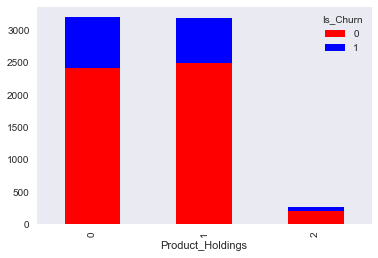

In [26]:
# Combining Product_Holdings and Is_Churn
temp = pd.crosstab(train_df['Product_Holdings'], train_df['Is_Churn'])
temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)
plt.show()

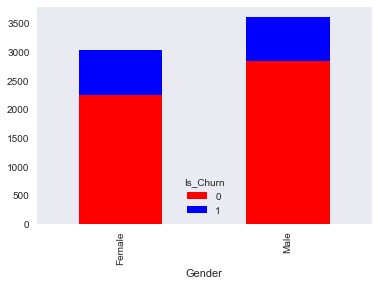

In [27]:
# Combining Gender and Is_Churn
temp = pd.crosstab(train_df['Gender'], train_df['Is_Churn'])
temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)
plt.show()

In [28]:
# Numerical encoding of Categorical variables
var_mod = ['Gender']
le = LabelEncoder()
for i in var_mod:
    train_df[i] = le.fit_transform(train_df[i])
    test_df[i] = le.transform(test_df[i])
combine = [train_df, test_df]
train_df.head(10)

,ID,Age,Gender,Income,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn,Balance_log
0,84e2fcc9,2,0,1,4,0,0,0,1,1,13.241508
1,57fea15e,6,0,0,2,1,0,1,0,0,13.682633
2,8df34ef3,2,0,3,2,1,1,0,0,0,13.461129
3,c5c0788b,4,0,3,0,1,1,1,0,1,14.147632
4,951d69c4,3,0,3,1,1,0,1,2,1,13.702506
5,e7a8332a,1,0,0,4,1,0,0,2,0,11.617527
6,f2de1836,6,1,0,2,1,1,1,1,0,13.885132
7,f422388a,3,0,2,4,0,0,1,0,1,14.277665
8,773aa149,7,0,2,0,0,0,1,0,1,14.197920
9,443be80f,2,0,1,3,0,0,1,0,0,13.555180


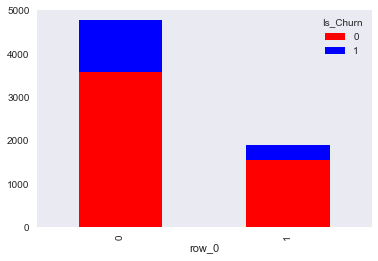

In [29]:
temp = pd.crosstab(train_df['Gender']*train_df['Transaction_Status'], train_df['Is_Churn'])
temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)
plt.show()

### Next, let us look at the correlation between different attributes using a heatmap.

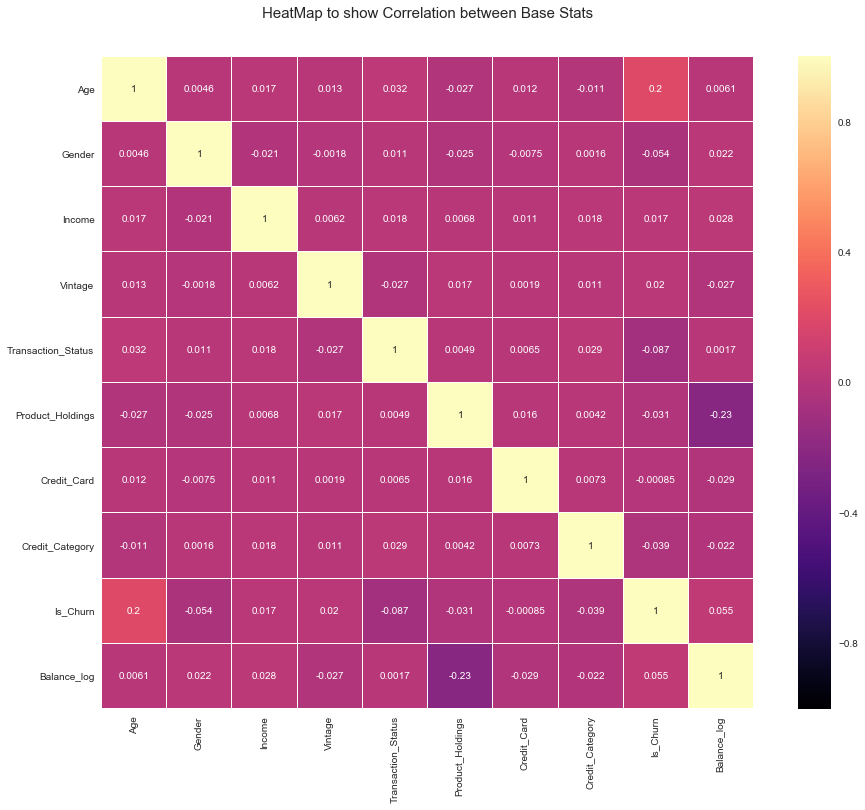

In [30]:
Corr = train_df
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('HeatMap to show Correlation between Base Stats', y=1.05, size=15)
sns.heatmap(Corr.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Feature importance

In [31]:
train_df.corrwith(train_df["Is_Churn"])

Age                   0.202411
Gender               -0.053589
Income                0.016866
Vintage               0.020152
Transaction_Status   -0.086917
Product_Holdings     -0.030769
Credit_Card          -0.000848
Credit_Category      -0.038788
Is_Churn              1.000000
Balance_log           0.054627
dtype: float64

### Creating new features

Since Age had the highest correlation with the target variable, we created several new features that are non-linear transformations namely elementwise powers of the Age feature. We also used element-wise product of the Age and Transaction Status feature (with 0’s replaced by -1’s) and similarly the element-wise product of the Age and the Gender feature (with Females replaced by -1 and Males replaced by +1 ). We created 4 more features which are combinations of the Transaction feature and the Gender feature i.e. the Transaction and the Gender features are both binary and there are 4 possibilities that each pair of them can take (0,0), (0,1), (1,0) and (1,1); We created a one-hot encoding of this set of 4 possibilities i.e. each one-hot encoded feature is 1 when only one particular possibility is true and is 0 otherwise.

In [32]:
for dataset in combine:
    dataset['Age'] = dataset['Age']+1
    dataset['Age2'] = dataset['Age']**2
    dataset['Age3'] = dataset['Age']**3
    dataset['Age4'] = dataset['Age']**4
    dataset['Age5'] = dataset['Age']**5
    dataset['Age6'] = dataset['Age']**6
train_df.head(10)    

,ID,Age,Gender,Income,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn,Balance_log,Age2,Age3,Age4,Age5,Age6
0,84e2fcc9,3,0,1,4,0,0,0,1,1,13.241508,9,27,81,243,729
1,57fea15e,7,0,0,2,1,0,1,0,0,13.682633,49,343,2401,16807,117649
2,8df34ef3,3,0,3,2,1,1,0,0,0,13.461129,9,27,81,243,729
3,c5c0788b,5,0,3,0,1,1,1,0,1,14.147632,25,125,625,3125,15625
4,951d69c4,4,0,3,1,1,0,1,2,1,13.702506,16,64,256,1024,4096
5,e7a8332a,2,0,0,4,1,0,0,2,0,11.617527,4,8,16,32,64
6,f2de1836,7,1,0,2,1,1,1,1,0,13.885132,49,343,2401,16807,117649
7,f422388a,4,0,2,4,0,0,1,0,1,14.277665,16,64,256,1024,4096
8,773aa149,8,0,2,0,0,0,1,0,1,14.197920,64,512,4096,32768,262144
9,443be80f,3,0,1,3,0,0,1,0,0,13.555180,9,27,81,243,729


In [33]:
for dataset in combine:
    dataset['Gender_Transaction'] = dataset['Gender']+(2*dataset['Transaction_Status'])
    dataset['Transaction_Status_rescaled'] = 2*dataset['Transaction_Status']-1
    dataset['Gender_rescaled'] = 2*dataset['Gender']-1    

In [34]:
for dataset in combine:
    dataset['Age_transaction_combination'] = dataset['Transaction_Status_rescaled']*dataset['Age']
    dataset['Age_gender_combination'] = dataset['Gender_rescaled']*dataset['Age']
train_df.head(10)    

,ID,Age,Gender,Income,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn,...,Age2,Age3,Age4,Age5,Age6,Gender_Transaction,Transaction_Status_rescaled,Gender_rescaled,Age_transaction_combination,Age_gender_combination
0,84e2fcc9,3,0,1,4,0,0,0,1,1,...,9,27,81,243,729,0,-1,-1,-3,-3
1,57fea15e,7,0,0,2,1,0,1,0,0,...,49,343,2401,16807,117649,2,1,-1,7,-7
2,8df34ef3,3,0,3,2,1,1,0,0,0,...,9,27,81,243,729,2,1,-1,3,-3
3,c5c0788b,5,0,3,0,1,1,1,0,1,...,25,125,625,3125,15625,2,1,-1,5,-5
4,951d69c4,4,0,3,1,1,0,1,2,1,...,16,64,256,1024,4096,2,1,-1,4,-4
5,e7a8332a,2,0,0,4,1,0,0,2,0,...,4,8,16,32,64,2,1,-1,2,-2
6,f2de1836,7,1,0,2,1,1,1,1,0,...,49,343,2401,16807,117649,3,1,1,7,7
7,f422388a,4,0,2,4,0,0,1,0,1,...,16,64,256,1024,4096,0,-1,-1,-4,-4
8,773aa149,8,0,2,0,0,0,1,0,1,...,64,512,4096,32768,262144,0,-1,-1,-8,-8
9,443be80f,3,0,1,3,0,0,1,0,0,...,9,27,81,243,729,0,-1,-1,-3,-3


### Feature importance of all features including new ones

In [35]:
train_df.corrwith(train_df["Is_Churn"])

Age                            0.202411
Gender                        -0.053589
Income                         0.016866
Vintage                        0.020152
Transaction_Status            -0.086917
Product_Holdings              -0.030769
Credit_Card                   -0.000848
Credit_Category               -0.038788
Is_Churn                       1.000000
Balance_log                    0.054627
Age2                           0.195615
Age3                           0.183263
Age4                           0.169509
Age5                           0.156196
Age6                           0.144066
Gender_Transaction            -0.101257
Transaction_Status_rescaled   -0.086917
Gender_rescaled               -0.053589
Age_transaction_combination   -0.081872
Age_gender_combination        -0.058363
dtype: float64

### Feature selection

In [36]:
X = train_df[['Gender_Transaction', 'Gender', 'Transaction_Status']]
X_test = test_df[['Gender_Transaction', 'Gender', 'Transaction_Status']]
X_remaining = train_df[['Balance_log', 'Age', 'Product_Holdings','Credit_Category', 'Age2', 'Age3', 'Age4', 'Age5', 'Age6', 'Age_transaction_combination', 'Age_gender_combination']].values
X_test_remaining = test_df[['Balance_log', 'Age', 'Product_Holdings','Credit_Category', 'Age2', 'Age3', 'Age4', 'Age5', 'Age6', 'Age_transaction_combination', 'Age_gender_combination']].values
Y = train_df["Is_Churn"]

In [37]:
enc = OneHotEncoder(handle_unknown='ignore')
X = enc.fit_transform(X).toarray()
X_test = enc.transform(X_test).toarray()
print(X.shape)
print(X_test.shape)

(6650, 8)
(2851, 8)


In [38]:
X=np.append(X, X_remaining, 1)
X_test=np.append(X_test, X_test_remaining, 1)
print(X.shape)
print(X_test.shape)

(6650, 19)
(2851, 19)


## Model fitting

In [39]:
# generic function
def modelfit(alg, X, Y, cv, X_test):
    
    #Perform cross-validation:
    cv_score = cross_val_score(alg, X, Y, cv=cv, scoring='f1_macro')
    
    #Print model report:
    print("\nModel Report")
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Fit the algorithm on the data
    alg.fit(X, Y)
    
    #Predict on training data:
    Y_pred_train = alg.predict(X)
    
    #Macro F1 score on training data
    macro_f1_score=f1_score(Y, Y_pred_train, average='macro')
    print("Training Macro F1 score - %.4g" % macro_f1_score)
        
    #Predict on testing data:
    Y_pred = alg.predict(X_test)
    
    return Y_pred


## Few Base Models

In [40]:
# Logistic Regression with L2 penalty
logreg_l2 = LogisticRegression(random_state=0, penalty='l2', tol=1e-6, C=0.95, class_weight={0:0.3, 1:0.7}, solver='liblinear')
Y_pred = modelfit(logreg_l2, X, Y, 10, X_test)


Model Report
CV Score : Mean - 0.5927 | Std - 0.01983 | Min - 0.5682 | Max - 0.6238
Training Macro F1 score - 0.5976


In [41]:
# Logistic Regression with L1 penalty
logreg_l1 = LogisticRegression(random_state=0, penalty='l1', tol=1e-6, C=0.95, class_weight={0:0.3, 1:0.7}, solver='liblinear')
Y_pred = modelfit(logreg_l1, X, Y, 10, X_test)


Model Report
CV Score : Mean - 0.5942 | Std - 0.02085 | Min - 0.5614 | Max - 0.6266
Training Macro F1 score - 0.5956


In [42]:
# LDA
lda = LinearDiscriminantAnalysis()
Y_pred = modelfit(lda, X, Y, 10, X_test)


Model Report
CV Score : Mean - 0.4953 | Std - 0.01687 | Min - 0.4717 | Max - 0.5323
Training Macro F1 score - 0.4963


In [43]:
# Perceptron
perceptron = Perceptron(random_state=0, penalty='l2', class_weight={0:0.3, 1:0.7})
Y_pred = modelfit(perceptron, X, Y, 10, X_test)


Model Report
CV Score : Mean - 0.4371 | Std - 0.1329 | Min - 0.1878 | Max - 0.5735
Training Macro F1 score - 0.4347


In [44]:
# Linear SVC
linear_svc = LinearSVC(random_state=0, class_weight={0:0.3, 1:0.7}, dual=False, tol=1e-6, C=0.2)
Y_pred = modelfit(linear_svc, X, Y, 10, X_test)


Model Report
CV Score : Mean - 0.5918 | Std - 0.0207 | Min - 0.5557 | Max - 0.6292
Training Macro F1 score - 0.5949


In [45]:
# Decision Tree Model
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=30, max_features="auto", min_samples_split=2, class_weight={0:0.3, 1:0.7})
Y_pred = modelfit(decision_tree, X, Y, 10, X_test)


Model Report
CV Score : Mean - 0.5225 | Std - 0.02165 | Min - 0.4664 | Max - 0.5437
Training Macro F1 score - 0.9994


In [46]:
# Random Forest
random_forest = RandomForestClassifier(random_state=0, n_estimators=50, max_depth=30, max_features="auto", min_samples_split=5, bootstrap=True,  class_weight={0:0.3, 1:0.7})
Y_pred = modelfit(random_forest, X, Y, 10, X_test)


Model Report
CV Score : Mean - 0.5407 | Std - 0.0167 | Min - 0.519 | Max - 0.5711
Training Macro F1 score - 0.9023


In [47]:
# XGB Classifier
gbm = xgb.XGBClassifier(random_state=0, max_depth=30, n_estimators=50, learning_rate=0.5, class_weight={0:0.3, 1:0.7})
Y_pred = modelfit(gbm, X, Y, 10, X_test)


Model Report
CV Score : Mean - 0.5219 | Std - 0.02065 | Min - 0.4934 | Max - 0.5708
Training Macro F1 score - 0.9962


In [48]:
# k-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 3)
Y_pred = modelfit(knn, X, Y, 10, X_test)


Model Report
CV Score : Mean - 0.5284 | Std - 0.01612 | Min - 0.4952 | Max - 0.5514
Training Macro F1 score - 0.7236


In [49]:
# Naive Bayes
gaussian = GaussianNB()
Y_pred = modelfit(gaussian, X, Y, 10, X_test)


Model Report
CV Score : Mean - 0.5499 | Std - 0.02749 | Min - 0.5022 | Max - 0.609
Training Macro F1 score - 0.5507


## Best Model

In [50]:
# Logistic Regression with L1 penalty
logreg_l1 = LogisticRegression(random_state=0, penalty='l1', tol=1e-6, C=0.95, class_weight={0:0.3, 1:0.7}, solver='liblinear')
Y_pred = modelfit(logreg_l1, X, Y, 10, X_test)


Model Report
CV Score : Mean - 0.5942 | Std - 0.02085 | Min - 0.5614 | Max - 0.6266
Training Macro F1 score - 0.5956


In [51]:
submission = pd.DataFrame({
        "ID": test_df["ID"],
        "Is_Churn": Y_pred
    })

submission.to_csv('best_solution.csv', index=False)